</hr>

# Approximating the Brachistochrone Curve with a Genetic Algorithm

Vivek Gopalakrishnan | June 9, 2018


**Problem setup:**

Find the least-time path between two points in 2-dimensional space. Assume friction is negligible and that all particles experience a uniform gravitational field.

**Theory:**

This project aims to numerically approximate the Brachistochrone, the path of least-time connecting two points. The path of least-time is defined as the path that, if followed by a particle, would take the least time to travel from one point to another. From classical proofs derived in the 1600s, we know know that this path is a cycloid, the curve obtained by tracing the path of a singular point on a wheel as the wheel rolls through space. Instead of using proof, I indend to find the least-time path using a genetic algorithm.

**Algorithm Outline:**

1. Two points are randomly initialized and fixed in two-dimensional space. 
2. A population of random paths are generated. 
3. The times required to travel these paths are calculated (*time* is the genetic algorithm's fitness score). 
4. Paths with high fitness scores are more likely to be selected in the mating pool. The pool randomly combines different parent paths to create a new generation of paths.
5. Iterate through steps 3 and 4 until the fitnesses converge.
6. Visualize these curves and compare to the theoretical values.

**References:**
- [Brachistochrone Curve](https://en.wikipedia.org/wiki/Brachistochrone_curve)
- [Genetic Algorithms](http://natureofcode.com/book/chapter-9-the-evolution-of-code/)

<hr>

## Step 1: Initialize the endpoints

In [1]:
# Data storage and RNG
import numpy as np

In [2]:
def init_path():
    y = np.random.rand(1,2)
    p1 = (0, 0)
    p2 = (1, np.random.uniform(-1,0))
    
    return p1, p2

In [3]:
p1, p2 = init_path()
print(p1, p2)

(0, 0) (1, -0.7972472702838733)


## Step 2: Make a random path

To make the initial generation of paths more useful, some constraints are placed on the algorithm. Paths must:
1. Be bounded by the endpoints
2. Be differentiable

In [4]:
# Interpolation
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

# Plotting
GOLDEN = (1 + 5 ** 0.5) / 2
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def generate_path(p1, p2, SEL=0):
    
    # Seperate x's and y's
    x = [p[0] for p in [p1,p2]]
    y = [p[1] for p in [p1,p2]]
    
    # Linearly interpolate the two points
    f = interp1d(x, y, kind='linear')
    
    # Make the domain
    x = np.linspace(0,1,26)
    y = []
    
    # Fill in the range
    for index, coord in enumerate(x):
        
        # Bound the curve at the two points p1 and p2
        if (coord == min(x)):
            y.append(p1[1])
        elif (coord == max(x)):
            y.append(p2[1])
            
        # For every point excluding the boundary, add noise
        else:
            y.append(f(coord) + np.random.uniform(-1,0))
    
    # Iterpolate the data (x, y) to create the path
    f2 = UnivariateSpline(x, y, k=4, s=0)
    
    if SEL == 1:
        return x, y, f2
    else:
        return f2

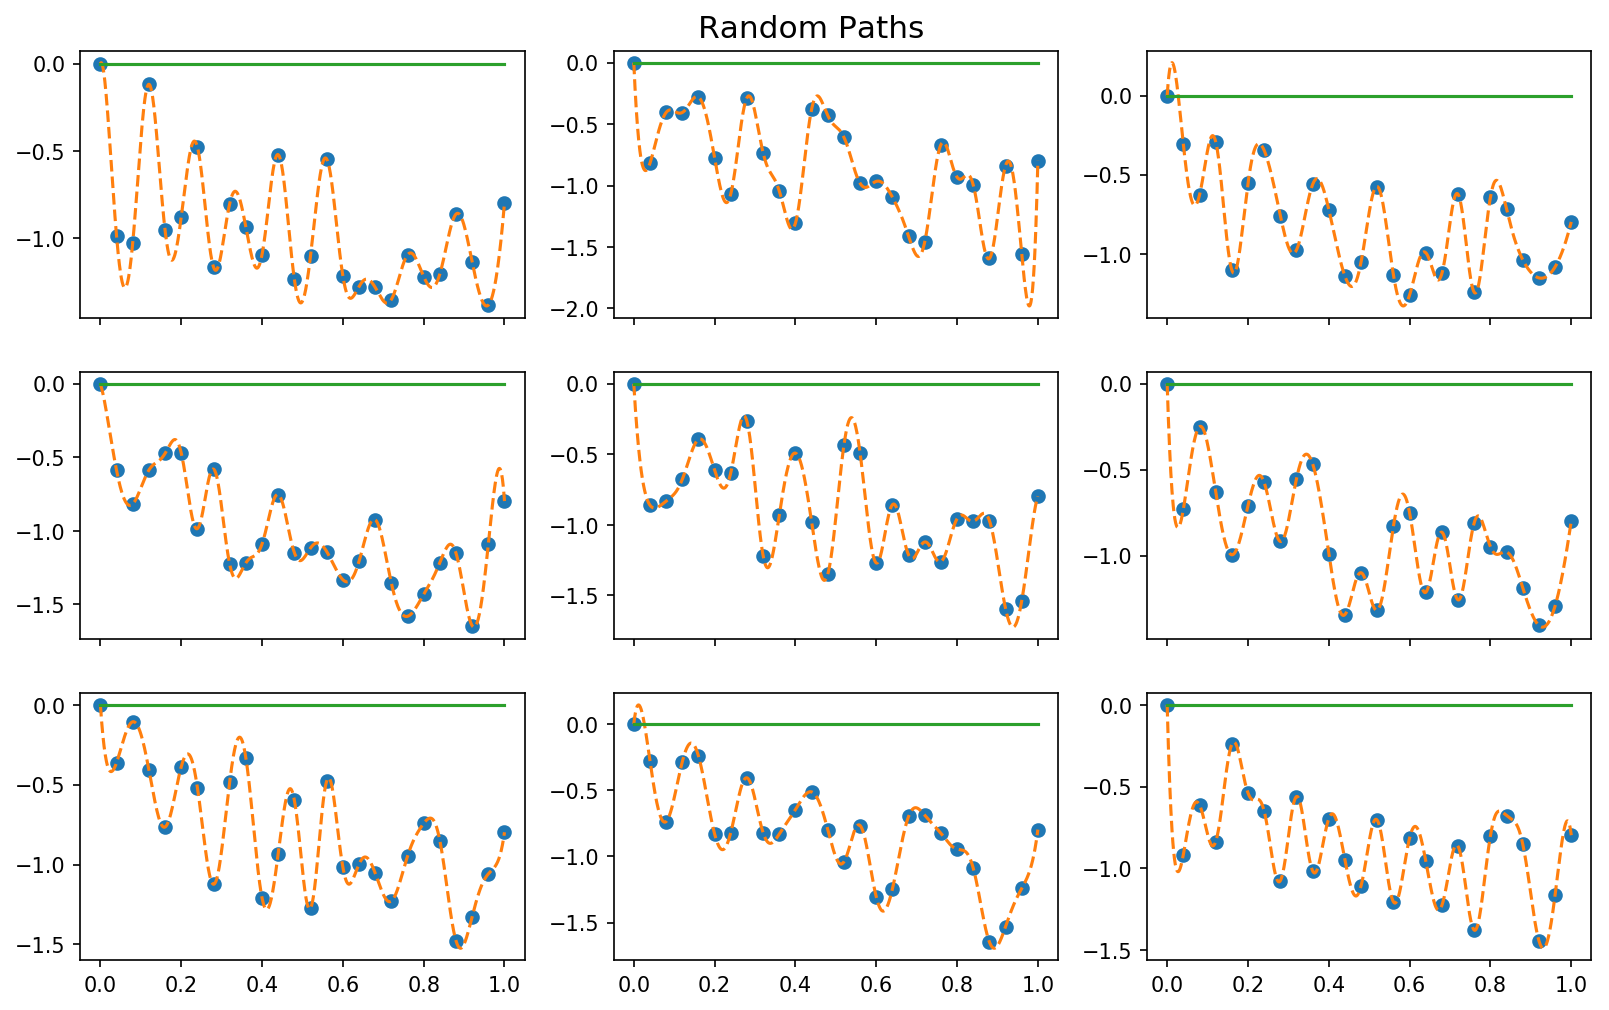

In [6]:
# Visualize the paths

# Figure specification
fig, ax = plt.subplots(figsize=(13,13/GOLDEN), dpi=150,
                       ncols=3, nrows=3, sharex='all'
                      )

# Title
fig.suptitle("Random Paths", 
             fontsize=15,
             y=0.91
            )

# Loop plotting
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        x, y, f2 = generate_path(p1, p2, SEL=1)
        xnew = np.linspace(0,1,1001)
        ax[i][j].plot(x, y, 'o', 
                      xnew, f2(xnew), '--',
                      xnew, [0]*len(xnew)
                     )

# Render
plt.show()

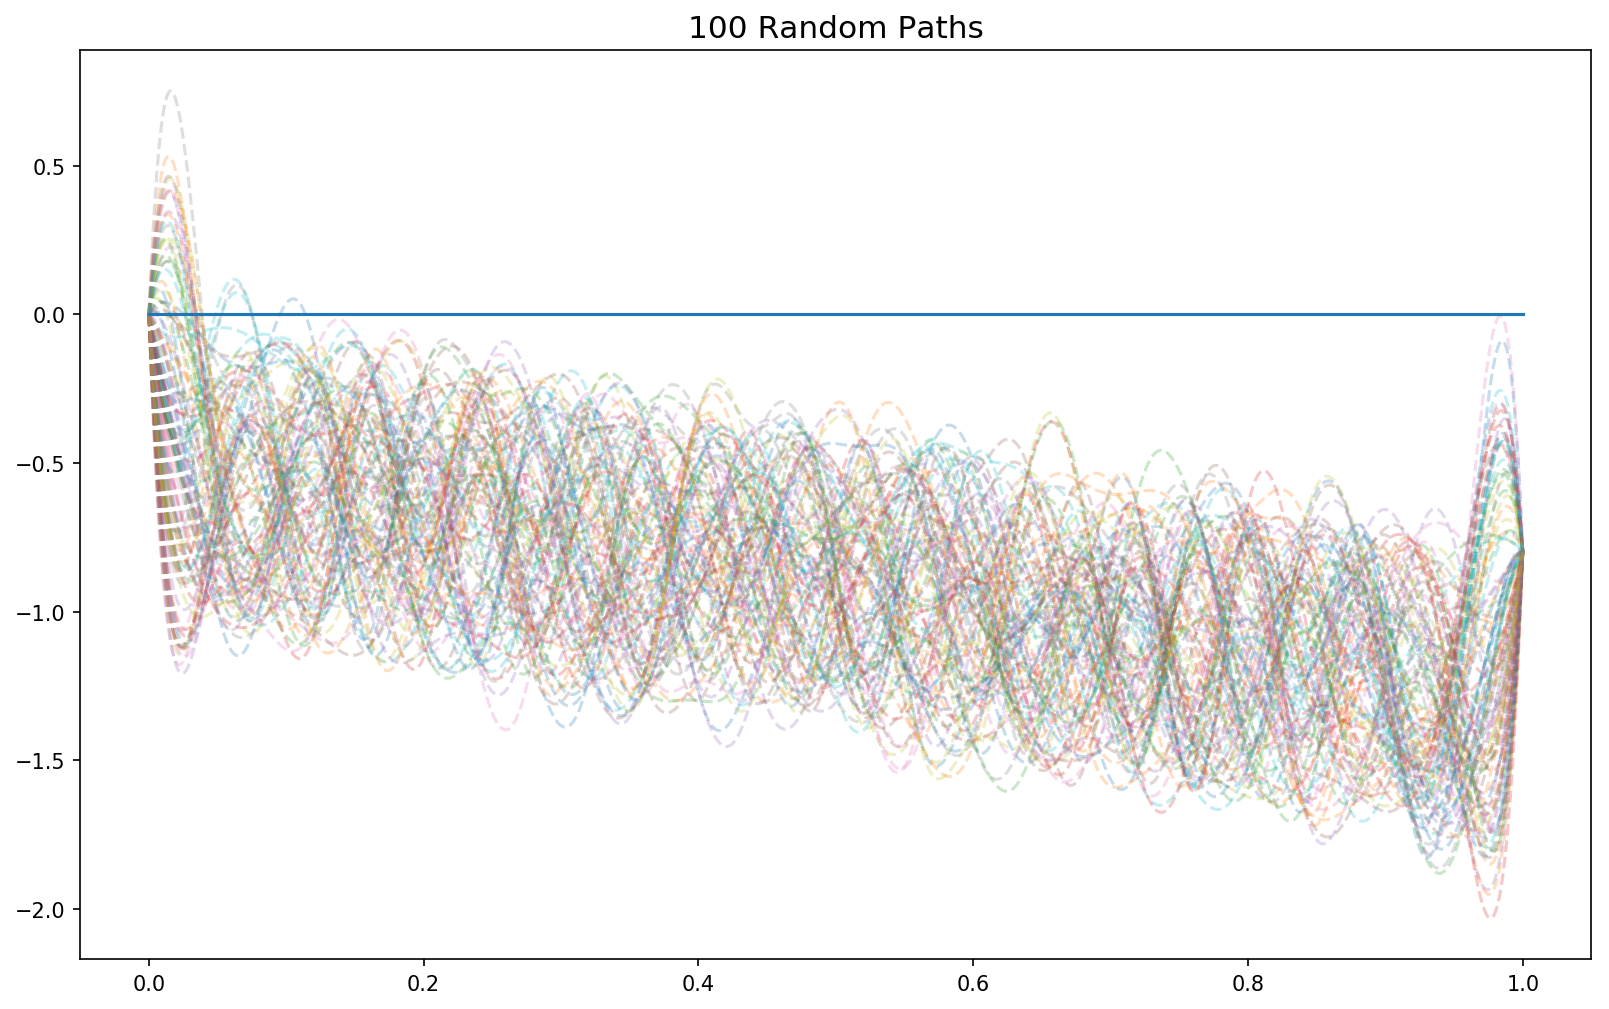

In [7]:
# Plot 100 random paths

# Make figure
plt.figure(figsize=(13, 13/GOLDEN), dpi=150)

# Domain
xnew = np.linspace(0,1,1001)

# Plot path
for i in range(100):
    x, y, f2 = generate_path(p1, p2, SEL=1)
    plt.plot(xnew, f2(xnew), '--', alpha=0.25)

# Plot y=0 limit
plt.plot(xnew, [0]*len(xnew))

# Render
plt.title("100 Random Paths", fontsize=15)
plt.show()

## Step 3: Fitness function

The parameter we are trying to optimize time; therefore, a logical output for the fitness function would be the time it takes a particle to travel along the random path. To simplify the calculation for time, assume the particle travelling this path is a point mass, friction is negligble, and that the particle starts at rest.

The following derivation of the time $T$ required to travel that path is motivated from the simple observation 
$$ v = \frac{ds}{dt} \Leftrightarrow dt = \frac{ds}{v}$$


Because we are assuming a uniform gravitational field, the total energy of the system as a function of x is

$$E(x) = K + U_g = \frac{1}{2}mv(x)^2 + mgh(x) = \frac{1}{2}mv(x)^2 + mgf(x)$$


Additionally, because the particle starts at rest 
$$E(x=0)=0$$

Combining these equations, we see
$$\frac{1}{2}mv(x)^2 + mgf(x) = 0$$

$$v(x)^2 = -2gf(x)$$

$$v(x) \propto \sqrt{-f(x)}$$


To find the total displacement along the curve ($ds$) for a differential movement in the x direction ($dx$), we can use the arc length formula:
$$ds = dx \sqrt{1 + f'(x)^2}$$

Then, the time to move $ds$ along $f(x)$ is given by $dt = \frac{ds}{v(x)}$. Thus, the time $T$ required to traverse the path $y=f(x)$ is as follows:
$$T(f(x)) = \int{dt} = \int_{0}^{x_n} \frac{ds}{v(x)} = \int_{0}^{x_n} \sqrt{\frac{1 + f'(x)^2}{-f(x)}}dx$$

**Remark:** In the procedure for generating a random path, all points are bound below $y=0$; however, it is not possible to bound the interpolated function below this threshold. From an energistic standpoint, a curve that rises above $y=0$ is insurmountable because the particle starts with $E=0$. This behavior is numerically conserved by the fact that the formula for $T$ cannot be evaluated if $f(x) \geq 0$ for $x \in [0,1]$. For our purposes, we define $T=\infty$ in these cases.

**Definition of the fitness function:** Define the fitness function $F$ as 
$$F(f(x)) = T(f(x))^{-1}$$
The fitness of a given curve is inversely proportional to the time required to traverse it. Thus, the function is bounded by $0 \leq F(f(x)) \leq 1$; invalid curves (those for which $T=\infty$) will have a fitness of $F=0$ while the fitness of all valid curves will be greater than 0.

### Implementation:
Below is an implementation of this integral for one curve:

In [8]:
# Numerical tools
from scipy import integrate
from math import sqrt

In [9]:
# Fitness function `dt`
dt = lambda t: sqrt( (1 + f2.derivative()(t)**2) / (-f2(t)) )

In [10]:
# Calculate the fitness for a single path
try:
    print(integrate.quad(dt,a=0,b=1,limit=250))
except:
    print("Invalid curve.")

Invalid curve.


We can simulate a population of curves and evaluate each of their times as follows:

In [11]:
# Generate 50 random paths
paths = [generate_path(p1, p2) for i in range(50)]

# Lists to hold T**-1 and associated error
inv_times = []
error = []

# Calculate time
for f2 in paths:
    dt = lambda t: sqrt( (1 + f2.derivative()(t)** 2)  / -f2(t))
    
    try: 
        time = integrate.quad(dt, a=0, b=1, limit=250)
        inv_times.append(time[0] ** -1)
        error.append(time[1])
    except: 
        # Exception occurs if f(x)>0 for x in [0,1]
        time = np.inf
        inv_times.append(time ** -1)
        error.append(0)

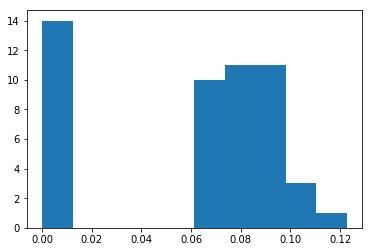

In [12]:
# Plot the population's fitness scores
plt.hist(inv_times)
plt.show()

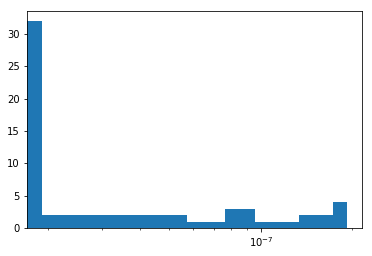

In [13]:
# Plot the estimated error from numerical integration
plt.hist(error)
plt.xscale('log')
plt.show()

## Section 4: Assembling class structures

We now have a framework for generating paths and evaluating their fitness. Let us group these methods under a single class.

**`Path` Attributes:**
1. `x`: x-coords
2. `y`: y-coords
3. `f2`: interplolated path
4. `mutation_rate`: rate of mutation in reproduction

**`Path` Methods:**
1. `generate_path`: Generate a random path
2. `reproduction`: Create a child path from 2 parent paths
3. `evaluate`: Evaluate the time needed to traverse the path
4. `visualize`: Render the plot

In [131]:
class Path():
    """A class holding the attributes of an individual path."""
    
    def __init__(self, external_path=None, mutation_rate=0.1):
        """Initialize the class."""
        
        # Make a path 
        if external_path == None:
            path = self.generate_path(p1, p2)
        else:
            path = external_path
        
        # Assign the x-coords, y-coods, and function as attributes
        self.x = path[0]
        self.y = path[1]
        self.f2 = path[2]
        
        # Constants
        self.mutation_rate = mutation_rate
        
        # Geneology
        self.parent_A = path[3]
        self.parent_B = path[4]
        
    def generate_path(self, p1, p2):
        """Returns a path for the particle to follow."""

        # Seperate x's and y's
        x = [p[0] for p in [p1,p2]]
        y = [p[1] for p in [p1,p2]]

        # Linearly interpolate the two points
        f = interp1d(x, y, kind='linear')

        # Make the domain
        x = np.linspace(0,1,26)
        y = []

        # Fill in the range
        for index, coord in enumerate(x):

            # Bound the curve at the two points p1 and p2
            if (coord == min(x)):
                y.append(p1[1])
            elif (coord == max(x)):
                y.append(p2[1])

            # For every point excluding the boundary, add uniform noise
            else:
                y.append(f(coord) + np.random.uniform(-1,0))

        # Iterpolate the data (x, y) to create the path
        f2 = UnivariateSpline(x, y, k=4, s=0)

        # Return x-coords, y-coords, and interpolated function    
        return x, y, f2, None, None
    
    
    def reproduction(self, partner):
        """Returns a genetic offspring of two paths."""
        
        # Create empty array for the child's y-path
        child_y = [0] * (len(self.y) - 2)
        
        # Create the child's y-path
        for i in range(len(child_y)):
            if i < int(round((len(self.y)-1)/2)):
                child_y[i] = self.y[i+1]
            else:
                child_y[i] = partner.y[i+1]
                
            for i in range(len(child_y)):
                # If the random float is less than the mutation rate, then that y-coord is random
                if np.random.uniform(0, 1) < self.mutation_rate:
                    child_y[i] = np.random.uniform(-2, -0.1)
        child_y.insert(0, 0)
        child_y.insert(-1, self.y[-1])
                
        # Mutate the child's y-path
        for i in range(len(child_y)):
            # If the random float is less than the mutation rate, then that y-coord is random
            if np.random.uniform(0, 1) < self.mutation_rate:
                child_y[i] = np.random.uniform(-2, -0.1)
                
        # Return the interpolated child path
        x = np.linspace(0,1,26)
        y = child_y
        f2 = UnivariateSpline(x, y, k=4, s=0)
        child = [x, y, f2, self, partner]

        return child
    
    
    def evaluate(self):
        """Returns the inverse time required to traverse a path and error estimation."""
        
        # Differential time as a function of x
        dt = lambda x: sqrt( (1 + self.f2.derivative()(x)**2) / (-self.f2(x)) )
        
        # Integrate dt over the domain [0,1]
        try: 
            T = integrate.quad(dt, a=0, b=1, limit=250)
            T_inv = T[0] ** (-1)
            err = T[1]
            self.valid = True
            
        except: 
            # Exception occurs if f(x)>0 for x in [0,1]
            T = np.inf
            T_inv = T ** (-1)
            err = 0
            self.valid = False
            
        return T_inv, err
    
    def visualize(self, title=None):
        """Returns a plot of the interpolated path."""
        
        # A more granular domain
        xnew = np.linspace(0,1,1001)
        
        # Plot setup
        plt.plot(self.x, self.y, 'o',        # Original points
                 xnew, self.f2(xnew), '--',  # Interpolated path
                 xnew, [0]*len(xnew)         # Cutoff line at y=0
                )
        # Plot titles
        if title != None:
            plt.title(title)
        plt.xlabel('x')
        plt.ylabel('y')
        
        # Render
        plt.show()

(0.0924838540538539, 5.829436844351221e-08)


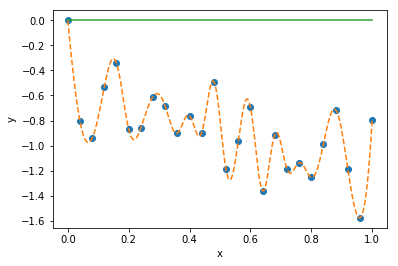

In [77]:
path = Path()
print(path.evaluate())
path.visualize()

A `Population` class can be used to organize multiple paths in a single object.

**`Population` Attributes:**
1. `population_size`: Size of population
2. `population`: List of paths
3. `fitness`: Raw fitness scores
4. `normalized_fitness`: Normalized fitness scores
5. `error`: Numerical integration error estimate

**`Population` Methods:**
1. `evaluate`: Evaluate fitness of every path in population
2. `assemble_pool`: Return a mating pool from the existing curves
3. `generate_offspring`: Return new curve from 2 offspring in the mating pool
4. `next_generation`: Make the next generation of curves
5. `hist_fitness_and_error`: Return histograms of error and fitness values

In [58]:
from random import choice

In [119]:
class Population():
    """A class holding a population of paths."""
    
    def __init__(self, n_paths=100):
        
        # Generate a specified number of paths
        self.population_size = n_paths
        self.population = [Path() for i in range(self.population_size)]
        
        # Path evaluation
        self.fitness = None
        self.normalized_fitness = None
        self.error = None
        
        # Mating pool and parent selection
        self.mating_pool = []
        
        # Historical records
        self.historical_fitness = []
        self.historical_error = []
        self.generation = 0
    
    """Hidden functions for processing fitness and error."""
    # 1. Calculate the T^(-1) for each path
    cohort_evaluate = lambda self: [path.evaluate()[0] for path in self.population]
    # 2. Calculate the error estimate
    cohort_error = lambda self: [path.evaluate()[1] for path in self.population]
    
    def evaluate(self):
        
        # Evaluate the fitness, normalized fitness, and error
        self.fitness = [path.evaluate()[0] for path in self.population]
        self.normalized_fitness = [F/max(self.fitness) for F in self.fitness]
        self.error = [path.evaluate()[1] for path in self.population]
        
        # Save the measurements
        self.historical_fitness.append(self.fitness)
        self.historical_error.append(self.error)
        
        
    def assemble_pool(self):
        """Return a mating pool from the existing curves."""
        for i in range(len(self.population)):
            
            if self.normalized_fitness[i] != 0:
                # If the path is valid
                n = int(self.normalized_fitness[i] * 100)
            else:
                # Else if the path is invalid
                n = 0
            
            # Add n copies of the path to the mating pool
            for j in range(n):
                self.mating_pool.append(self.population[i])
         
        
    def generate_offspring(self):
        """Return new curve from 2 offspring in the mating pool."""
        
        # Array for holding offspring paths
        new_paths = [0] * self.population_size
        
        for i in range(self.population_size):

            # Randomly pick the y-coords from two parents
            parent_A = choice(self.mating_pool)
            parent_B = choice(self.mating_pool)
            
            # Remove parent_A and parent_B from mating pool
            self.mating_pool.remove(parent_A)
            self.mating_pool.remove(parent_B)

            # Create child using crossover function
            child = parent_A.reproduction(parent_B)

            # Add new rocket to next generation
            new_paths[i] = Path(external_path=child)

        self.population = new_paths
        
        
    def next_generation(self):
        self.evaluate()
        self.assemble_pool()
        self.generate_offspring()
        self.generation += 1
    
    
    def hist_fitness_and_error(self, generation):
        """Return histograms of error and fitness."""
        fig, ax = plt.subplots(figsize=(6,6/GOLDEN),
                               ncols=2, nrows=1)
        
        # Plot 1: normalized fitness histogram
        ax[0].hist(self.historical_fitness[generation])
        ax[0].set_title('Fitness Scores')
        ax[0].set_xlabel('Score ' + r'($T^{-1})$')
        ax[0].set_ylabel('Frequency')
        
        # Plot 2: error histogram
        ax[1].hist(self.historical_error[generation])
        ax[1].set_title('Error')
        ax[1].set_xscale('log')
        ax[1].set_xlabel('Error estimate')
        ax[1].set_ylabel('Frequency')
        
        # Render
        plt.tight_layout()
        plt.show()

In [135]:
pop = Population(n_paths=50)

for i in range(1):
    
    pop.evaluate()
    
    print(pop.generation, np.mean(pop.fitness))
    
    pop.assemble_pool()
    pop.generate_offspring()
    
    pop.generation += 1
    
pop.evaluate()
print(pop.generation, np.mean(pop.fitness))

0 0.059889764861301736
1 0.0316961186772691


In [136]:
pop.historical_fitness[-1]

[0.046159157737938245,
 0.056080479317617934,
 0.04321894208967557,
 0.05139537854805836,
 0.0,
 0.06433868834858955,
 0.0,
 0.049785365282992856,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05086581906771008,
 0.0,
 0.0,
 0.040906089633175914,
 0.0,
 0.0,
 0.0,
 0.05074243018829383,
 0.0,
 0.04981599100674866,
 0.0678094274173894,
 0.0,
 0.052919018934467627,
 0.059996648381590266,
 0.0,
 0.05045874406530751,
 0.05804394257773808,
 0.08214206863191753,
 0.0,
 0.04433857664041409,
 0.05440929926339609,
 0.0,
 0.0,
 0.056207906832328396,
 0.06168548575068904,
 0.0,
 0.06160384061927972,
 0.04804559620151705,
 0.0699647985926916,
 0.05135160548319441,
 0.0,
 0.0,
 0.061442632628193966,
 0.04193885455690546,
 0.05685219080227834,
 0.054388622454792465,
 0.04789833280856272]

In [152]:
zeros = [i for i in range(50) if pop.historical_fitness[-1][i] == 0]

In [153]:
zeros

[4,
 6,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 17,
 18,
 19,
 21,
 24,
 27,
 31,
 34,
 35,
 38,
 43,
 44]

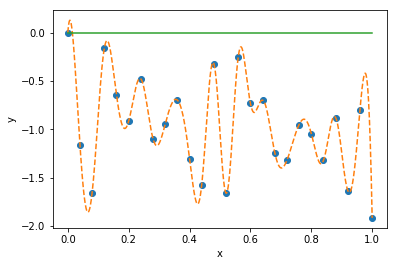

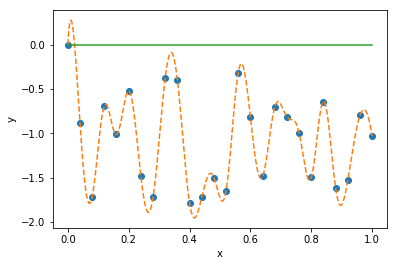

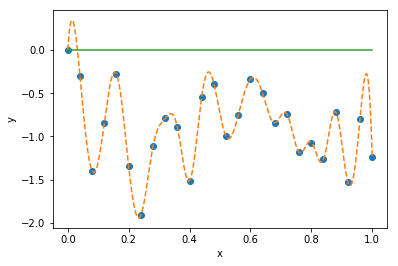

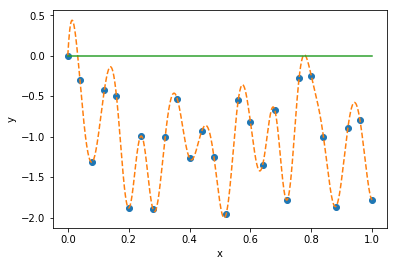

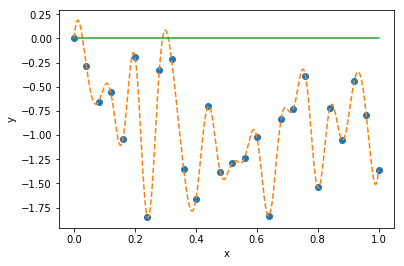

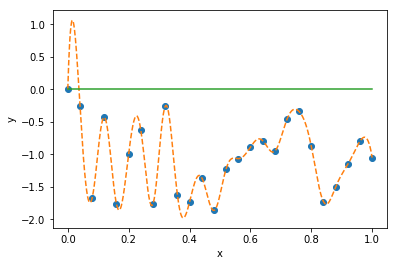

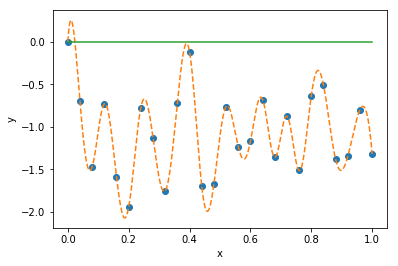

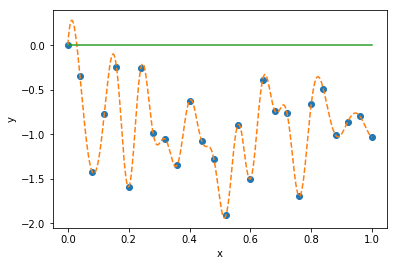

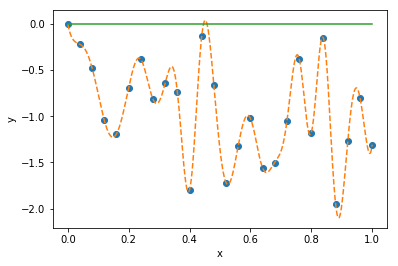

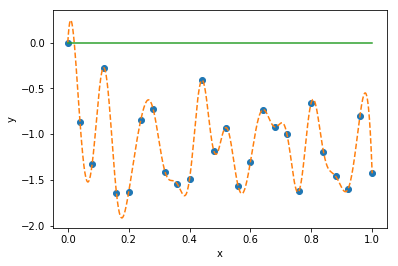

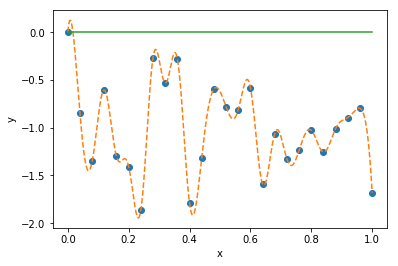

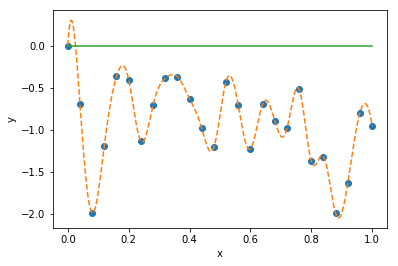

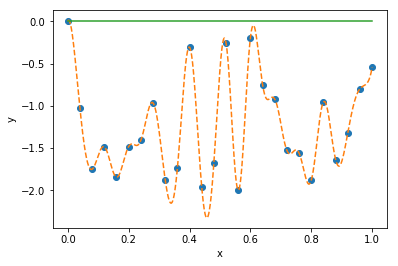

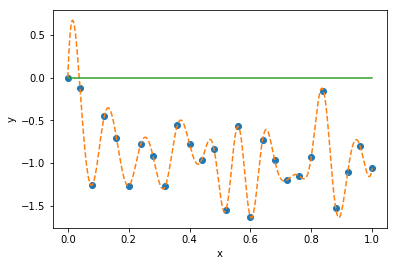

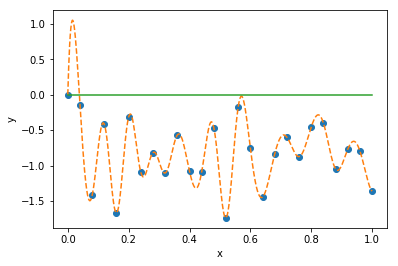

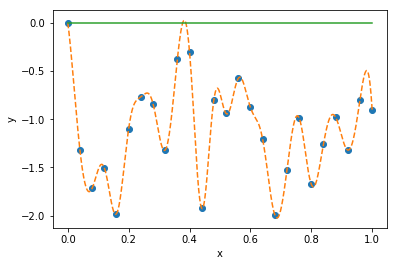

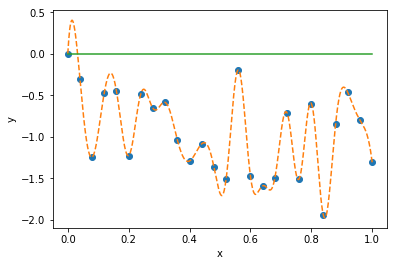

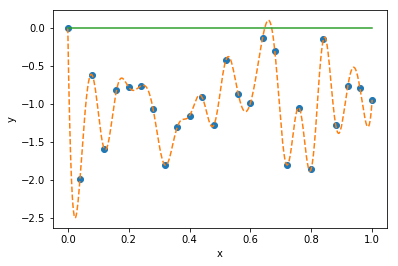

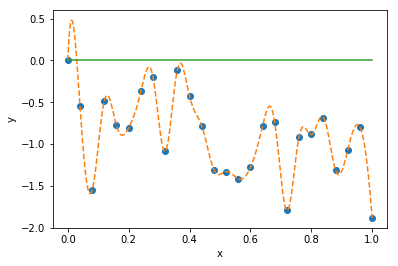

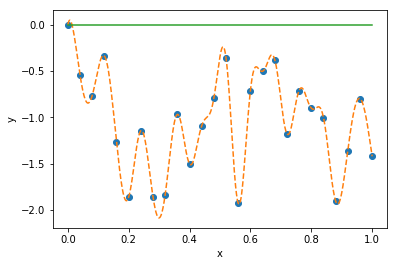

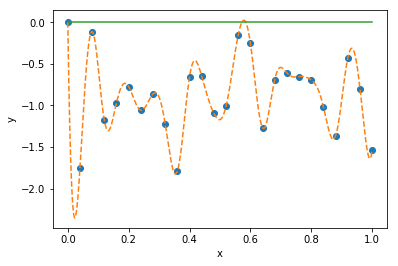

In [154]:
for i in zeros:
    pop.population[i].visualize()

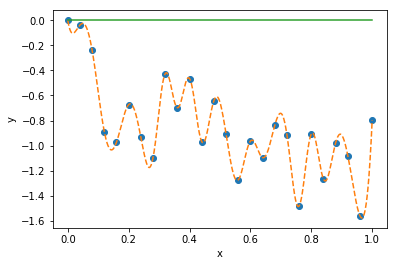

In [138]:
pop.population[4].parent_A.visualize()

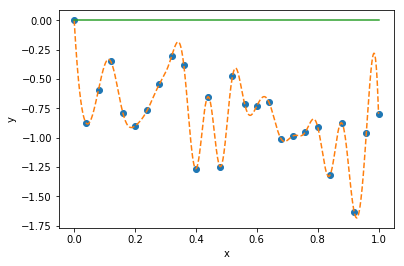

In [139]:
pop.population[4].parent_B.visualize()

In [140]:
child = (pop.population[4].parent_A).reproduction((pop.population[4].parent_B))

In [142]:
child = Path(child)

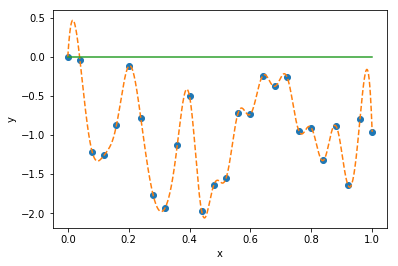

In [143]:
child.visualize()

In [144]:
a = [1]
a.index(1)

0